# **Starter**

In [1]:
cd /content/drive/MyDrive/TACS/hmog/public_dataset/

[Errno 2] No such file or directory: '/content/drive/MyDrive/TACS/hmog/public_dataset/'
/content


# **Imports**

In [ ]:
!pip install pyeer

     |████████████████████████████████| 614kB 5.7MB/s 
  Created wheel for pyeer: filename=pyeer-0.5.4-cp36-none-any.whl size=603835 sha256=2cb17995a83ad7bd2914d3364ad8515ca1e858ee6579fa93d542cba953eedb67
  Stored in directory: /root/.cache/pip/wheels/8c/26/2e/39ca25f59deb5f470fbb378f70b79033719582d9c894e9803f
Successfully built pyeer


In [ ]:
import pyeer
import json
import pandas as pd
from datetime import datetime
import pickle
import scipy.stats
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, InputLayer

In [ ]:
def pickling(fname, obj):
  f = open(fname, "wb")
  pickle.dump(obj, f)
  f.close()

def unpickling(fname):
  f = open(fname, 'rb')
  g = pickle.load(f) 
  f.close()
  return g

# **Data Parsing**

In [ ]:
users = unpickling('saved_objects/users.pkl')

# **Preprocessing**

### Helper functions

In [ ]:
def pickup_user(u):
  #assumed the user id exists and the directory is right
  d = {}
  for i in range(24):
    d[i + 1] = {}
    ss = u + '/' + u+'_' + 'session' + '_' + str(i+1)
    d[i + 1]['task'] = int(pd.read_csv(ss + '/Activity.csv', header = None, usecols = [8], names =['at'])['at'][0])
    d[i+1]['touch'] = pd.read_csv(ss + '/' + 'TouchEvent.csv', header = None, usecols = list(range(11)), names=['systime', 'etime', 'actid', 'ptrcnt', 'ptrid', 'actionid', 'X', 'Y', 'pressure', 'csize', 'orientation'])
    d[i+1]['accelerometer'] = pd.read_csv(ss + '/Accelerometer.csv', header = None, usecols = list(range(7)), names = ['systime', 'etime', 'actid', 'X', 'Y', 'Z', 'orientation'])
    d[i+1]['magnetometer'] = pd.read_csv(ss + '/Magnetometer.csv', header=None, usecols = list(range(7)), names = ['systime', 'etime', 'actid', 'X', 'Y', 'Z', 'orientation'])
    d[i+1]['gyroscope'] = pd.read_csv(ss + '/Gyroscope.csv', header=None,usecols = list(range(7)), names = ['systime', 'etime', 'actid', 'X', 'Y', 'Z', 'orientation'])
  return d

In [ ]:
def get_dist(x1, y1, x2, y2):
  return np.sqrt((x1-x2)**2 + (y1 - y2)**2)

In [ ]:
def mid_stroke_pressure(a):
  if len(a)%2 == 0:
    return (a[len(a)//2]['pressure'] + a[(len(a)//2) - 1]['pressure'])/2
  return a[len(a)//2]['pressure']

In [ ]:
def length_of_stroke(a):
  d = 0
  for i in range(1,len(a)):
    d += get_dist(a[i-1]['X'], a[i-1]['Y'], a[i]['X'], a[i]['Y'])
  return d

In [ ]:
def get_vx(a):
  v = []
  for i in range(1, len(a)):
    d = a[i]['X'] - a[i-1]['X']
    t = a[i]['systime'] - a[i-1]['systime']
    if(t == 0):
      v.append(v[-1])
      continue
    v.append(d/t)
  return v

In [ ]:
def get_vy(a):
  v = []
  for i in range(1, len(a)):
    d = a[i]['Y'] - a[i-1]['Y']
    t = a[i]['systime'] - a[i-1]['systime']
    if(t == 0):
      v.append(v[-1])
      continue
    v.append(d/t)
  return v

In [ ]:
def get_ax(a, vx):
  vx = np.concatenate((vx, [0]))
  ax = []
  for i in range(1, len(a)):
    dv = vx[i] - vx[i-1]
    t = a[i]['systime'] - a[i-1]['systime']
    if t == 0:
      ax.append(ax[-1])
      continue
    ax.append(dv/t)
  return ax

In [ ]:
def get_ay(a, vy):
  vy = np.concatenate((vy, [0]))
  ay = []
  for i in range(1, len(a)):
    dv = vy[i] - vy[i-1]
    t = a[i]['systime'] - a[i-1]['systime']
    if(t == 0):
      ay.append(ay[-1])
      continue
    ay.append(dv/t)
  return ay

In [ ]:
def swipe_to_features(a):
  X = []
  vx = np.array(get_vx(a))
  vy = np.array(get_vy(a))
  ax = np.array(get_ax(a, vx))
  ay = np.array(get_ay(a, vy))
  ps = np.array([i['pressure'] for i in a])
  cs = np.array([i['csize'] for i in a])

  X.append(a[-1]['systime'] - a[0]['systime'])
  X.append(a[0]['X'])
  X.append(a[0]['Y'])
  X.append(a[-1]['X'])
  X.append(a[-1]['Y'])
  X.append(np.min(vx))
  X.append(np.max(vx))
  X.append(np.min(vy))
  X.append(np.max(vy))
  X.append(np.mean(vx))
  X.append(np.mean(vy))
  X.append(np.std(vx))
  X.append(np.std(vy))
  X.append(np.var(vx))
  X.append(np.var(vy))
  X.append(np.min(ax))
  X.append(np.max(ax))
  X.append(np.mean(ax))
  X.append(np.std(ax))
  X.append(np.var(ax))
  X.append(np.min(ay))
  X.append(np.max(ay))
  X.append(np.mean(ay))
  X.append(np.std(ay))
  X.append(np.var(ay))
  X.append(np.min(ps))
  X.append(np.max(ps))
  X.append(np.mean(ps))
  X.append(np.std(ps))
  X.append(np.var(ps))
  l = length_of_stroke(a)
  X.append(l)
  d = get_dist(a[0]['X'], a[0]['Y'], a[-1]['X'], a[-1]['X'])
  X.append(d)
  X.append(np.min(cs))
  X.append(np.max(cs))
  X.append(np.mean(cs))
  X.append(np.std(cs))
  X.append(np.var(cs))
  return (X, a[0]['systime'], a[-1]['systime'], d, l)


In [ ]:
def extract_touches(df):
  swipes = []
  swipe = []
  for index, row in df.iterrows():
    if(row['orientation'] != 0):
      continue
    if(row['ptrcnt'] != 1):
      continue
    if(row['actionid'] in [0, 5]):
      swipe.append(row)
      continue
    if(row['actionid'] == 2):
      if(len(swipe) > 0 and row['systime'] == swipe[-1]['systime']):
        continue
      else:
        swipe.append(row)
    if(row['actionid'] in [1, 6]):
      if(row['systime'] != swipe[-1]['systime']):
        swipe.append(row)
      if(len(swipe) <= 7):
        swipe = []
        continue
      fset = swipe_to_features(swipe)
      if(fset[4] < 0.01):
        swipe = []
        continue
      swipes.append(swipe_to_features(swipe))
      swipe = []
  return swipes

In [ ]:
def sensor_to_feature(a):
  X = []
  xs = [i['X'] for i in a]
  ys = [i['Y'] for i in a]
  zs = [i['Z'] for i in a]
  M = [np.sqrt(i['X']**2 + i['Y']**2 + i['Z']**2) for i in a]
  X.append(np.mean(xs))
  X.append(np.mean(ys))
  X.append(np.mean(zs))
  X.append(np.mean(M))
  X.append(np.std(xs))
  X.append(np.std(ys))
  X.append(np.std(zs))
  X.append(np.std(M))
  X.append(scipy.stats.skew(xs))
  X.append(scipy.stats.skew(ys))
  X.append(scipy.stats.skew(zs))
  X.append(scipy.stats.skew(M))
  X.append(scipy.stats.kurtosis(xs))
  X.append(scipy.stats.kurtosis(ys))
  X.append(scipy.stats.kurtosis(zs))
  X.append(scipy.stats.kurtosis(M))
  return X

In [ ]:
def extract_sensor(df, swipes):
  data_points = []
  pt = []
  i = 0
  for index, row in df.iterrows():
    if( i >= len(swipes)):
      continue
    if(row['systime'] < swipes[i][1]):
      continue
    if(row['systime'] >= swipes[i][1] and row['systime'] <= swipes[i][2]):
      pt.append(row)
    if(row['systime'] >= swipes[i][2]):
      i += 1
      data_points.append(sensor_to_feature(pt))
      pt = []
  return data_points
      

In [ ]:
def get_features(u):
  #input: user id
  u = pickup_user(u)
  # u = unpickling('saved_objects/' + u + '_data.pkl')
  d = {0: None, 1: None}
  for ss in range(24):
    sw = extract_touches(u[ss+1]['touch'])
    swipes = np.array([i[0] for i in sw])
    ac = np.array(extract_sensor(u[ss+1]['accelerometer'], sw))
    gy = np.array(extract_sensor(u[ss+1]['gyroscope'], sw))
    mag = np.array(extract_sensor(u[ss+1]['magnetometer'], sw))
    if(u[ss + 1]['task']%6 in [1, 2]):
      tt = np.array([1, 0, 0])
    if(u[ss + 1]['task']%6 in [3, 4]):
      tt = np.array([0, 1, 0])
    if(u[ss + 1]['task']%6 in [0, 5]):
      tt = np.array([0, 0, 1])
    if(swipes.shape[0] == 0):
      continue
    print(swipes.shape, ac.shape, gy.shape, mag.shape)
    vectors = np.concatenate((swipes, ac, gy, mag), axis = 1)
    c = np.tile(tt[np.newaxis,:], (vectors.shape[0],1))
    vectors = np.concatenate((vectors, c), axis = 1)
    if(type(d[u[ss+1]['task']%2]) == type(None)):
      d[u[ss+1]['task']%2] = vectors
    else:
      d[u[ss+1]['task']%2] = np.concatenate((d[u[ss+1]['task']%2], vectors))
  return d

    

### Feature vector generation

In [ ]:
i = 0
for user in users[56:]:
  print ("User#" + str(i), user)
  v = get_features(user)
  pickling('saved_objects/' + user + "_features2.pkl", v)
  i += 1


# **Evaluation**

In [ ]:
def getCounts(predicted, actual, label):
	tp, tn, fn, fp = 0, 0, 0, 0
	for i in range(len(predicted)):
		if(predicted[i] == label and actual[i] == label):
			tp += 1
		elif(predicted[i] != label and actual[i] != label):
			tn += 1
		elif(predicted[i] == label and actual[i] != label):
			fp += 1
		elif(predicted[i] != label and actual[i] == label):
			fn += 1
	return {'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn}

In [ ]:
def TAR(predicted, actual, label):
  d = getCounts(predicted, actual, label)
  return d['tp']/(d['tp'] + d['fn'])

In [ ]:
def FAR(predicted, actual, label):
  d = getCounts(predicted, actual, label)
  return d['fp']/(d['fp'] + d['tn'])

In [ ]:
def FRR(predicted, actual, label):
  d = getCounts(predicted, actual, label)
  return d['fn']/(d['fn'] + d['tp'])

In [ ]:
def TRR(predicted, actual, label):
  d = getCounts(predicted, actual, label)
  return d['tn']/(d['tn'] + d['fp'])

# **Walking**

## Loading Data

In [ ]:
a =[]
for i in range(1, 50):
  a.append(unpickling('saved_objects/' + users[i] + "_features2.pkl"))
u = unpickling('saved_objects/' + users[0] + '_features2.pkl')

In [ ]:
data = u[0]
labels = [1]*len(data)

In [ ]:
for i in a:
  r = np.random.choice(len(i[0]), size = 30, replace=False)
  data = np.concatenate((data, i[0][r, :]))
  labels += [0]*len(r)

In [ ]:
labels = np.array(labels)

In [ ]:
labels = labels.reshape(-1, 1)

In [ ]:
train = np.concatenate((data, labels), axis = 1)

In [ ]:
np.random.shuffle(train)

In [ ]:
X_t = train[:,:-1]
Y_t = train[:,-1]

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(X_t, Y_t, test_size = 0.2, random_state = 42 ,stratify = Y_t)

## Single Swipe

### Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth = 12, n_estimators=1000, criterion = 'entropy', random_state=100)
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.9992779783393502
Test 0.950937950937951
TAR: 0.9699248120300752
TRR: 0.9251700680272109
F1 Score: 0.9579207920792079


### Gaussian Naive Bayes

In [ ]:
clf = GaussianNB()
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.6563176895306859
Test 0.645021645021645
TAR: 0.9624060150375939
TRR: 0.21428571428571427
F1 Score: 0.757396449704142


### KNN

In [ ]:
clf = KNeighborsClassifier(3, metric='cosine')
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.8833935018050542
Test 0.7503607503607503
TAR: 0.8170426065162907
TRR: 0.6598639455782312
F1 Score: 0.7903030303030303


### SVC

In [ ]:
clf = SVC(random_state=0)
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.7794223826714801
Test 0.7489177489177489
TAR: 0.8370927318295739
TRR: 0.6292517006802721
F1 Score: 0.7933491686460807


### MLP

In [ ]:
clf = MLPClassifier()
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.903971119133574
Test 0.8643578643578643
TAR: 0.8421052631578947
TRR: 0.8945578231292517
F1 Score: 0.877284595300261


## Multi-Swipe

In [ ]:
X = []
Y = []
look_back = 5
for i in range(len(u[1])-look_back):
  r = u[1][i]
  for j in range(1, look_back):
    r = np.concatenate((r, u[1][i+j]))
  X.append(r)
  Y.append(1)

for k in a:
  for i in range(min(len(k[1])-look_back, 200)):
    r = k[1][i]
    for j in range(1, look_back):
      r = np.concatenate((r, k[1][i+j]))
    X.append(r)
    Y.append(0)
X = np.array(X)
Y = np.array(Y)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, stratify=Y, test_size = 0.2)

### Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth = 11, n_estimators=100, criterion = 'entropy', random_state=100)
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 1.0
Test 0.9987124463519313
TAR: 0.991869918699187
TRR: 1.0
F1 Score: 0.9959183673469388


### Gaussian Naive Bayes

In [ ]:
clf = GaussianNB()
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.7382204572287216
Test 0.7536480686695279
TAR: 0.9322493224932249
TRR: 0.7200407955124937
F1 Score: 0.5451664025356576


### KNN

In [ ]:
clf = KNeighborsClassifier(3, metric='cosine')
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.9281957711709777
Test 0.869098712446352
TAR: 0.4823848238482385
TRR: 0.9418663946965834
F1 Score: 0.5385779122541604


### SVC

In [ ]:
clf = SVC(random_state=0)
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.855532896855211
Test 0.8566523605150215
TAR: 0.10298102981029811
TRR: 0.998470168281489
F1 Score: 0.1853658536585366


### MLP

In [ ]:
clf = MLPClassifier()
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.9828270902651068
Test 0.9545064377682403
TAR: 0.8319783197831978
TRR: 0.9775624681285059
F1 Score: 0.8527777777777777


## Final Results

In [ ]:
models = ["RF", "GNB", "KNN", "SVC", "MLP"]

In [ ]:
results = {}

In [ ]:
results['single'] = {}
results['single']['train'] = [0.9992779783393502, 0.6563176895306859, 0.8833935018050542, 0.7794223826714801, 0.903971119133574]
results['single']['test'] = [0.9624819624819625, 0.645021645021645, 0.7503607503607503, 0.7489177489177489, 0.8643578643578643]
results['single']['tar'] = [0.9899749373433584, 0.9624060150375939, 0.8170426065162907, 0.8370927318295739, 0.8421052631578947]
results['single']['trr'] = [0.9251700680272109, 0.21428571428571427, 0.6598639455782312, 0.6292517006802721, 0.8945578231292517]
results['single']['f1score'] = [0.9681372549019607, 0.757396449704142, 0.7903030303030303, 0.7933491686460807, 0.877284595300261]

In [ ]:
results['multi'] = {}
results['multi']['train'] = [1.0, 0.7382204572287216, 0.9281957711709777, 0.855532896855211, 0.9828270902651068]
results['multi']['test'] = [0.9987124463519313, 0.7536480686695279, 0.869098712446352, 0.8566523605150215, 0.9545064377682403]
results['multi']['tar'] = [0.991869918699187, 0.9322493224932249, 0.4823848238482385, 0.10298102981029811, 0.8319783197831978]
results['multi']['trr'] = [1.0, 0.7200407955124937, 0.9418663946965834, 0.998470168281489, 0.9775624681285059]
results['multi']['f1score'] = [0.9959183673469388, 0.5451664025356576, 0.5385779122541604, 0.1853658536585366, 0.8527777777777777]

In [ ]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = float(rect.get_height())
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                str(height*100)[:5] + "%",
                ha='center', va='bottom')

# **Sitting**

## Classifier

In [ ]:
a =[]
for i in range(1, 50):
  a.append(unpickling('saved_objects/' + users[i] + "_features2.pkl"))
u = unpickling('saved_objects/' + users[0] + '_features2.pkl')

In [ ]:
data = u[1]
labels = [1]*len(data)

In [ ]:
for i in a:
  r = np.random.choice(len(i[0]), size = 30, replace=False)
  data = np.concatenate((data, i[0][r, :]))
  labels += [0]*len(r)

In [ ]:
labels = np.array(labels)

In [ ]:
labels = labels.reshape(-1, 1)

In [ ]:
train = np.concatenate((data, labels), axis = 1)

In [ ]:
np.random.shuffle(train)

In [ ]:
X_t = train[:,:-1]
Y_t = train[:,-1]

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(X_t, Y_t, test_size = 0.2, random_state = 42 ,stratify = Y_t)

# **Sitting**

### Single-Touch

### Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth = 12, n_estimators=1000, criterion = 'entropy', random_state=100)
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 1.0
Test 0.9954887218045113
TAR: 1.0
TRR: 0.9897959183673469
F1 Score: 0.9959731543624161


### Gaussian NB

In [ ]:
clf = GaussianNB()
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.9273616861121565
Test 0.9383458646616541
TAR: 0.9757412398921833
TRR: 0.891156462585034
F1 Score: 0.9464052287581699


### KNN

In [ ]:
clf = KNeighborsClassifier(3, metric='cosine')
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.8934888972525404
Test 0.8045112781954887
TAR: 0.8733153638814016
TRR: 0.717687074829932
F1 Score: 0.8329048843187661


### SVC

In [ ]:
clf = SVC(random_state=0)
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.8046669175762138
Test 0.793984962406015
TAR: 0.8571428571428571
TRR: 0.7142857142857143
F1 Score: 0.8227684346701163


### MLP

In [ ]:
clf = MLPClassifier()
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.9567181031238239
Test 0.9488721804511279
TAR: 0.9703504043126685
TRR: 0.9217687074829932
F1 Score: 0.9549071618037135


### Multi Touch

In [ ]:
X = []
Y = []
look_back = 5
for i in range(len(u[1])-look_back):
  r = u[1][i]
  for j in range(1, look_back):
    r = np.concatenate((r, u[1][i+j]))
  X.append(r)
  Y.append(1)

for k in a:
  for i in range(min(len(k[1])-look_back, 200)):
    r = k[1][i]
    for j in range(1, look_back):
      r = np.concatenate((r, k[1][i+j]))
    X.append(r)
    Y.append(0)
X = np.array(X)
Y = np.array(Y)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, stratify=Y, test_size = 0.2)

### RF

In [ ]:
clf = RandomForestClassifier(max_depth = 11, n_estimators=100, criterion = 'entropy', random_state=100)
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 1.0
Test 0.9978540772532188
TAR: 0.986449864498645
TRR: 1.0
F1 Score: 0.9931787175989086


### GNB

In [ ]:
clf = GaussianNB()
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.7261994204142964
Test 0.7098712446351931
TAR: 0.8915989159891599
TRR: 0.6756756756756757
F1 Score: 0.4932533733133434


### KNN

In [ ]:
clf = KNeighborsClassifier(3, metric='cosine')
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.927122464312547
Test 0.871244635193133
TAR: 0.5176151761517616
TRR: 0.9377868434472209
F1 Score: 0.560117302052786


### SVC

In [ ]:
clf = SVC(random_state=0)
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.8545669206826232
Test 0.8523605150214593
TAR: 0.07046070460704607
TRR: 0.9994900560938297
F1 Score: 0.1313131313131313


### MLP

In [ ]:
clf = MLPClassifier()
clf.fit(train_X, train_Y)
print ("Train", clf.score(train_X, train_Y))
print ("Test", clf.score(test_X, test_Y))
ypred = clf.predict(test_X)
print ("TAR:",TAR(ypred, test_Y,1))
print ("TRR:",TRR(ypred, test_Y, 1))
print("F1 Score:", f1_score(test_Y, ypred))

Train 0.9874423097563594
Test 0.9472103004291845
TAR: 0.8184281842818428
TRR: 0.971443141254462
F1 Score: 0.8308115543328749


## Final Results

In [ ]:
results2 = {}

In [ ]:
results2['single'] = {}
results2['single']['train'] = [1.0, 0.9273616861121565, 0.893488897252540, 0.8046669175762138, 0.9567181031238239]
results2['single']['test'] = [0.9954887218045113, 0.9383458646616541, 0.8045112781954887, 0.793984962406015, 0.9488721804511279]
results2['single']['tar'] = [1.0, 0.9757412398921833, 0.8733153638814016, 0.8571428571428571, 0.9703504043126685]
results2['single']['trr'] = [0.9897959183673469, 0.891156462585034, 0.717687074829932, 0.7142857142857143, 0.9217687074829932]
results2['single']['f1score'] = [0.9959731543624161, 0.9464052287581699, 0.8329048843187661, 0.8227684346701163, 0.9549]

In [ ]:
results2['multi'] = {}
results2['multi']['train'] = [1.0, 0.7261994204142964, 0.927122464312547, 0.8545669206826232, 0.9874423097563594]
results2['multi']['test'] = [0.9978540772532188, 0.7098712446351931, 0.871244635193133, 0.8523605150214593, 0.9472103004291845]
results2['multi']['tar'] = [0.986449864498645, 0.8915989159891599, 0.5176151761517616, 0.07046070460704607, 0.8184281842818428]
results2['multi']['trr'] = [1.0, 0.6756756756756757, 0.9377868434472209, 0.9994900560938297, 0.971443141254462]
results2['multi']['f1score'] = [0.9931787175989086, 0.4932533733133434, 0.560117302052786, 0.1313131313131313, 0.8308115543328749]

In [ ]:
names = ["Sitting-1-Swipe", "Sitting-5-Swipe", "Walking-1-Swipe", "Walking-5-Swipe"]
metric = 'f1score'
axx = [results2['single'][metric], results2['multi'][metric], results['single'][metric], results['multi'][metric]]
axx = np.array(axx)
axx = np.transpose(axx)

In [ ]:
axx = list(axx)

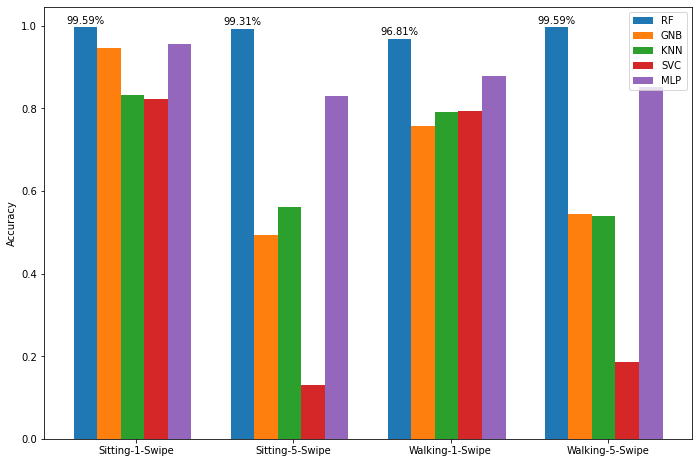

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_axes([0,0,1,1])
width = 0.15
ind = np.arange(4)
r1 = ax.bar(ind, axx[0], width)
r2 = ax.bar(ind + width, axx[1], width)
r3 = ax.bar(ind + width*2, axx[2], width)
r4 = ax.bar(ind + width*3, axx[3], width)
r5 = ax.bar(ind + width*4, axx[4], width)

ax.set_xticks(ind + width / 2 + 0.25)
ax.set_xticklabels(names)
autolabel(r1)
ax.legend((r1,r2,r3,r4,r5), models)
plt.ylabel("Accuracy")
fig.show()